In [27]:
# Packages
import os
import pandas as pd
from google.cloud import bigquery
from google.oauth2 import service_account

# Authenticate GCP/BQ and connect
credentials = service_account.Credentials.from_service_account_file(os.environ['gcp_credentials'])
project_id = 'freightwaves-data-science'
client = bigquery.Client(credentials=credentials, project=project_id)



In [20]:
# List of accessorial charges, ordered by number of occurrences
query_job = client.query("""
    select
      accessorial_charge_description
      ,count(accessorial_charge_description) count
    from `freightwaves-data-factory.warehouse.beetlejuice`
    group by accessorial_charge_description
    order by count(accessorial_charge_description) desc
    """)

query = query_job.result().to_dataframe()
query

,accessorial_charge_description,count
0,FUEL SURCHARGE,75296744
1,BASE CHARGE,25101305
2,FUEL CHARGE,19807731
3,DISCOUNT,11887577
4,BASE CHARGE ...,9760971
...,...,...
10183,INTERNATIONAL,1
10184,EXCEEDS LIMITED,1
10185,ADVANCE FEE ...,1
10186,FIXED ACCESSORIAL,1


In [3]:
# Percentage of all loads that have accessorial charges besides base & fuel
query_job = client.query("""
with all_loads as (
  select 
    count(distinct cass_shipment_id) as all_loads
  from `freightwaves-data-factory.warehouse.beetlejuice`
),
loads_with_true_accessorial as (
  select
    count(distinct cass_shipment_id) as loads_with_true_accessorial
  from `freightwaves-data-factory.warehouse.beetlejuice`
  where accessorial_charge_description not like "%Fuel%"
    and accessorial_charge_description not like "%FUEL%"
    and accessorial_charge_description not like "%BASE%"
)

select
  true_accessorial.loads_with_true_accessorial
  ,al.all_loads
  ,safe_divide(true_accessorial.loads_with_true_accessorial, al.all_loads) as pct_loads_with_accessorial
from all_loads as al
join loads_with_true_accessorial as true_accessorial
  on 1=1
""")

query = query_job.result().to_dataframe()
query.head()


,loads_with_true_accessorial,all_loads,pct_loads_with_accessorial
0,47454195,113217127,0.419143


In [4]:
# Percentage of all loads that have accessorial charges besides base & fuel, grouped by transportation mode
query_job = client.query("""
with all_loads as (
  select 
    count(distinct cass_shipment_id) as all_loads
    ,transportation_mode_description
  from `freightwaves-data-factory.warehouse.beetlejuice`
  group by transportation_mode_description
),
loads_with_true_accessorial as (
  select
    count(distinct cass_shipment_id) as loads_with_true_accessorial
    ,transportation_mode_description
  from `freightwaves-data-factory.warehouse.beetlejuice`
  where accessorial_charge_description not like "%Fuel%"
    and accessorial_charge_description not like "%FUEL%"
    and accessorial_charge_description not like "%BASE%"
  group by transportation_mode_description
)

select
  al.transportation_mode_description
  ,true_accessorial.loads_with_true_accessorial
  ,al.all_loads
  ,safe_divide(true_accessorial.loads_with_true_accessorial, al.all_loads) as pct_loads_with_accessorial
from all_loads as al
join loads_with_true_accessorial as true_accessorial
  on al.transportation_mode_description = true_accessorial.transportation_mode_description
order by safe_divide(true_accessorial.loads_with_true_accessorial, al.all_loads) desc
""")

query = query_job.result().to_dataframe()
query.head()


,transportation_mode_description,loads_with_true_accessorial,all_loads,pct_loads_with_accessorial
0,TOWAWAY SERVICE,1,1,1.0
1,BREAKBULK OCEAN,69,69,1.0
2,LEASE CARS,2,2,1.0
3,CUST PICKUP/EXPENSE,52883,52883,1.0
4,RAIL FLAT CAR,7,7,1.0


In [5]:
# Percentage of all loads that have accessorial charges besides base & fuel, grouped by origin and destination state
query_job = client.query("""
with all_loads as (
  select 
    count(distinct cass_shipment_id) as all_loads
    ,origin_state
    ,destination_state
  from `freightwaves-data-factory.warehouse.beetlejuice`
  group by origin_state
    ,destination_state
),
loads_with_true_accessorial as (
  select
    count(distinct cass_shipment_id) as loads_with_true_accessorial
    ,origin_state
    ,destination_state
  from `freightwaves-data-factory.warehouse.beetlejuice`
  where accessorial_charge_description not like "%Fuel%"
    and accessorial_charge_description not like "%FUEL%"
    and accessorial_charge_description not like "%BASE%"
  group by origin_state, destination_state
)

select
  al.origin_state
  ,al.destination_state
  ,true_accessorial.loads_with_true_accessorial
  ,al.all_loads
  ,safe_divide(true_accessorial.loads_with_true_accessorial, al.all_loads) as pct_loads_with_accessorial
from all_loads as al
join loads_with_true_accessorial as true_accessorial
  on al.origin_state = true_accessorial.origin_state
  and al.destination_state = true_accessorial.destination_state
order by safe_divide(true_accessorial.loads_with_true_accessorial, al.all_loads) desc, origin_state, destination_state
""")

query = query_job.result().to_dataframe()
query.head()

,origin_state,destination_state,loads_with_true_accessorial,all_loads,pct_loads_with_accessorial
0,*,KY,1,1,1.0
1,-,CO,4,4,1.0
2,.,.,2,2,1.0
3,.,KA,20,20,1.0
4,.,WE,2,2,1.0


In [6]:
# Percentage of all loads that have accessorial charges besides base & fuel, grouped by primary_naics_code
query_job = client.query("""
with all_loads as (
  select 
    count(distinct cass_shipment_id) as all_loads
    ,primary_naics_code
  from `freightwaves-data-factory.warehouse.beetlejuice`
  group by primary_naics_code
),
loads_with_true_accessorial as (
  select
    count(distinct cass_shipment_id) as loads_with_true_accessorial
    ,primary_naics_code
  from `freightwaves-data-factory.warehouse.beetlejuice`
  where accessorial_charge_description not like "%Fuel%"
    and accessorial_charge_description not like "%FUEL%"
    and accessorial_charge_description not like "%BASE%"
  group by primary_naics_code
)

select
  al.primary_naics_code
  ,true_accessorial.loads_with_true_accessorial
  ,al.all_loads
  ,safe_divide(true_accessorial.loads_with_true_accessorial, al.all_loads) as pct_loads_with_accessorial
from all_loads as al
join loads_with_true_accessorial as true_accessorial
  on al.primary_naics_code = true_accessorial.primary_naics_code
order by safe_divide(true_accessorial.loads_with_true_accessorial, al.all_loads) desc
""")

query = query_job.result().to_dataframe()
query.head()

,primary_naics_code,loads_with_true_accessorial,all_loads,pct_loads_with_accessorial
0,442299,3195,3195,1.0
1,323111,24,24,1.0
2,312112,4736,4736,1.0
3,336340,17,17,1.0
4,334419,71,71,1.0


In [14]:
# Total accessorial charges divided by total amount paid, by state-to-state lane
query_job = client.query("""
with accessorial_charges as (
  select 
    sum(accessorial_charge_amount) as accessorial_charges_sum
    ,cass_shipment_id
    ,origin_state
    ,destination_state
    ,accessorial_charge_description
  from `freightwaves-data-factory.warehouse.beetlejuice`
  where accessorial_charge_description not like "%Fuel%"
    and accessorial_charge_description not like "%FUEL%"
    and accessorial_charge_description not like "%BASE%"
    and amount_paid is not null
  group by
    cass_shipment_id
    ,origin_state
    ,destination_state
    ,accessorial_charge_description
  order by cass_shipment_id
),
total_accessorial_charges as (
  select
    sum(ac.accessorial_charges_sum) as total_accessorial_charges
    ,ac.origin_state
    ,ac.destination_state
  from accessorial_charges as ac
  group by ac.origin_state, ac.destination_state
),
amount_paid as (
  select
    max(amount_paid) as amount_paid
    ,cass_shipment_id
    ,origin_state
    ,destination_state
  from `freightwaves-data-factory.warehouse.beetlejuice`
  where amount_paid is not null
  group by
    cass_shipment_id
    ,origin_state
    ,destination_state
  order by cass_shipment_id
),
total_amount_paid as (
  select
    sum(ap.amount_paid) total_amount_paid
    ,ap.origin_state
    ,ap.destination_state
  from amount_paid as ap
  group by ap.origin_state, ap.destination_state
)

select
  t_acc.total_accessorial_charges
  ,t_amt.total_amount_paid
  ,safe_divide(t_acc.total_accessorial_charges, t_amt.total_amount_paid) as pct_of_total_charge
  ,t_acc.origin_state
  ,t_acc.destination_state
from total_accessorial_charges as t_acc
join total_amount_paid as t_amt
  on t_acc.origin_state = t_amt.origin_state
    and t_acc.destination_state = t_amt.destination_state
order by safe_divide(t_acc.total_accessorial_charges, t_amt.total_amount_paid) desc
""")

query = query_job.result().to_dataframe()
query.head()

,total_accessorial_charges,total_amount_paid,pct_of_total_charge,origin_state,destination_state
0,105.66,10.00,10.566000,AB,DK
1,40.00,4.00,10.000000,CA,HM
2,1023.57,113.03,9.055737,IN,NW
3,223.76,26.00,8.606154,CH,26
4,3286.04,494.78,6.641416,OR,38


In [13]:
# Total accessorial charges divided by total amount paid, by shipper
query_job = client.query("""
with accessorial_charges as (
  select 
    sum(accessorial_charge_amount) as accessorial_charges_sum
    ,cass_shipment_id
    ,shipper_master_code
    ,accessorial_charge_description
  from `freightwaves-data-factory.warehouse.beetlejuice`
  where accessorial_charge_description not like "%Fuel%"
    and accessorial_charge_description not like "%FUEL%"
    and accessorial_charge_description not like "%BASE%"
    and amount_paid is not null
  group by
    cass_shipment_id
    ,shipper_master_code
    ,accessorial_charge_description
  order by cass_shipment_id
),
total_accessorial_charges as (
  select
    sum(ac.accessorial_charges_sum) as total_accessorial_charges
    ,ac.shipper_master_code
  from accessorial_charges as ac
  group by ac.shipper_master_code
),
amount_paid as (
  select
    max(amount_paid) as amount_paid
    ,cass_shipment_id
    ,shipper_master_code
  from `freightwaves-data-factory.warehouse.beetlejuice`
  where amount_paid is not null
  group by
    cass_shipment_id
    ,shipper_master_code
  order by cass_shipment_id
),
total_amount_paid as (
  select
    sum(ap.amount_paid) total_amount_paid
    ,ap.shipper_master_code
  from amount_paid as ap
  group by ap.shipper_master_code
)

select
  t_acc.total_accessorial_charges
  ,t_amt.total_amount_paid
  ,safe_divide(t_acc.total_accessorial_charges, t_amt.total_amount_paid) as pct_of_total_charge
  ,t_acc.shipper_master_code
from total_accessorial_charges as t_acc
join total_amount_paid as t_amt
  on t_acc.shipper_master_code = t_amt.shipper_master_code
order by safe_divide(t_acc.total_accessorial_charges, t_amt.total_amount_paid) desc
""")

query = query_job.result().to_dataframe()
query.head()

,total_accessorial_charges,total_amount_paid,pct_of_total_charge,shipper_master_code
0,5.442882e+08,3.377535e+08,1.611496,1462
1,3.494128e+07,2.325528e+07,1.502509,1451
2,3.680420e+09,3.004877e+09,1.224815,1452
3,2.815714e+08,2.352466e+08,1.196920,1446
4,2.351371e+08,2.289762e+08,1.026906,1361


In [12]:
# Total accessorial charges divided by total amount paid, by carrier
query_job = client.query("""
with accessorial_charges as (
  select 
    sum(accessorial_charge_amount) as accessorial_charges_sum
    ,cass_shipment_id
    ,unique_carrier_id
    ,accessorial_charge_description
  from `freightwaves-data-factory.warehouse.beetlejuice`
  where accessorial_charge_description not like "%Fuel%"
    and accessorial_charge_description not like "%FUEL%"
    and accessorial_charge_description not like "%BASE%"
    and amount_paid is not null
  group by
    cass_shipment_id
    ,unique_carrier_id
    ,accessorial_charge_description
  order by cass_shipment_id
),
total_accessorial_charges as (
  select
    sum(ac.accessorial_charges_sum) as total_accessorial_charges
    ,ac.unique_carrier_id
  from accessorial_charges as ac
  group by ac.unique_carrier_id
),
amount_paid as (
  select
    max(amount_paid) as amount_paid
    ,cass_shipment_id
    ,unique_carrier_id
  from `freightwaves-data-factory.warehouse.beetlejuice`
  where amount_paid is not null
  group by
    cass_shipment_id
    ,unique_carrier_id
  order by cass_shipment_id
),
total_amount_paid as (
  select
    sum(ap.amount_paid) total_amount_paid
    ,ap.unique_carrier_id
  from amount_paid as ap
  group by ap.unique_carrier_id
)

select
  t_acc.total_accessorial_charges
  ,t_amt.total_amount_paid
  ,safe_divide(t_acc.total_accessorial_charges, t_amt.total_amount_paid) as pct_of_total_charge
  ,t_acc.unique_carrier_id
from total_accessorial_charges as t_acc
join total_amount_paid as t_amt
  on t_acc.unique_carrier_id = t_amt.unique_carrier_id
order by safe_divide(t_acc.total_accessorial_charges, t_amt.total_amount_paid) desc
""")

query = query_job.result().to_dataframe()
query.head()

,total_accessorial_charges,total_amount_paid,pct_of_total_charge,unique_carrier_id
0,150.00,1.00,150.000000,TL26164R26164
1,45.00,1.00,45.000000,FR61702F16511
2,740933.80,23852.84,31.062708,AR60666AM9W5S
3,63.00,7.00,9.000000,IS60197V28341
4,20831.25,3956.79,5.264684,PY61437P61437


In [17]:
# what are the highest-traffic lanes?
query_job = client.query("""
with data_with_lanes as (
  select
    *
    ,concat(origin_state, "-", destination_state) as state_lane
  from `freightwaves-data-factory.warehouse.beetlejuice`
),
lane_count as (
  select
    state_lane
    ,count(distinct cass_shipment_id) as loads_per_lane
  from data_with_lanes
  group by state_lane
  order by count(distinct cass_shipment_id) desc
)

select * from lane_count
""")

query = query_job.result().to_dataframe()
query.head()

,state_lane,loads_per_lane
0,None,7730333
1,TX-TX,4175031
2,CA-CA,4085325
3,MI-MI,2144762
4,ON-ON,1813248


In [19]:
# what is the variance in amount_paid for each lane, including all accessorial charges?
query_job = client.query("""
with data_with_lanes as (
  select
    *
    ,concat(origin_state, "-", destination_state) as state_lane
  from `freightwaves-data-factory.warehouse.beetlejuice`
  where amount_paid is not null
),
lane_count as (
  select
    state_lane
    ,accessorial_charge_description
    ,accessorial_charge_amount
    ,amount_paid
    ,cass_shipment_id
    ,count(distinct cass_shipment_id) over (partition by state_lane) as loads_per_lane
  from data_with_lanes
),
amount_paid_per_lane as (
  select
    state_lane
    ,cass_shipment_id
    ,loads_per_lane
    ,max(amount_paid) as amount_paid
  from lane_count
  group by cass_shipment_id, state_lane, loads_per_lane
),
raw_lane_variance as (
  select
    state_lane
    ,loads_per_lane
    ,round(variance(amount_paid), 1) as raw_lane_variance
  from amount_paid_per_lane
  where loads_per_lane > 100000
  group by state_lane, loads_per_lane
  order by raw_lane_variance desc
)

select * from raw_lane_variance

""")

query = query_job.result().to_dataframe()
query.head()

,state_lane,loads_per_lane,raw_lane_variance
0,None,7729124,1.692391e+11
1,TN-TN,381475,2.176810e+08
2,OH-OH,938172,1.157014e+08
3,BC-BC,244515,1.025314e+08
4,PA-PA,1298030,6.022887e+07


In [18]:
# what is the variance in amount_paid for each lane, excluding all lanes with more than just base charges?
query_job = client.query("""
with data_with_lanes as (
  select
    *
    ,concat(origin_state, "-", destination_state) as state_lane
  from `freightwaves-data-factory.warehouse.beetlejuice`
  where amount_paid is not null
),
lane_count as (
  select
    state_lane
    ,accessorial_charge_description
    ,accessorial_charge_amount
    ,amount_paid
    ,cass_shipment_id
    ,count(distinct cass_shipment_id) over (partition by state_lane) as loads_per_lane
  from data_with_lanes
),
loads_with_accessorials as (
  select
    distinct cass_shipment_id
  from lane_count
  where accessorial_charge_description not like "%BASE%"
),
loads_with_just_base as (
  select
    distinct lane_count.cass_shipment_id
  from lane_count
  left join loads_with_accessorials
    on lane_count.cass_shipment_id = loads_with_accessorials.cass_shipment_id
  where loads_with_accessorials.cass_shipment_id is null
),
amount_paid_per_lane as (
  select
    state_lane
    ,cass_shipment_id
    ,loads_per_lane
    ,max(amount_paid) as amount_paid
  from lane_count
  group by cass_shipment_id, state_lane, loads_per_lane
),
raw_lane_variance as (
  select
    state_lane
    ,loads_per_lane
    ,round(variance(amount_paid), 1) as raw_lane_variance
  from amount_paid_per_lane
  inner join loads_with_just_base
    on amount_paid_per_lane.cass_shipment_id = loads_with_just_base.cass_shipment_id
  where loads_per_lane > 100000
  group by state_lane, loads_per_lane
  order by raw_lane_variance desc
)

select * from raw_lane_variance
order by raw_lane_variance desc
""")

query = query_job.result().to_dataframe()
query.head()

,state_lane,loads_per_lane,raw_lane_variance
0,OH-OH,937808,6.305847e+09
1,KY-KY,931512,1.428808e+09
2,TN-TN,381419,3.797386e+08
3,LA-LA,254526,2.698203e+08
4,None,7727930,2.640856e+08


In [ ]:
# Comparing variance in paymnet for each lane, base vs base+fuel
query_job = client.query("""
with data_with_lanes as (
  select
    concat(origin_state, "-", destination_state) as state_lane
    ,accessorial_charge_description
    ,accessorial_charge_amount
    ,cass_shipment_id
  from `freightwaves-data-factory.warehouse.beetlejuice`
  where amount_paid is not null
),
lane_count as (
  select
    *
    ,count(distinct cass_shipment_id) over (partition by state_lane) as loads_per_lane
  from data_with_lanes
  where state_lane is not null
),
loads_with_base as (
  select * from lane_count
  where accessorial_charge_description like "%BASE%"
),
loads_with_base_and_fuel as (
  select * from lane_count
  where accessorial_charge_description like "%BASE%"
    or accessorial_charge_description like "%FUEL%"
    or accessorial_charge_description like "%Fuel%"
),
loads_with_base_summed as (
  select
    cass_shipment_id
    ,state_lane
    ,loads_per_lane
    ,sum(accessorial_charge_amount) as base_per_load
  from loads_with_base
  group by cass_shipment_id, state_lane, loads_per_lane
),
loads_with_base_fuel_summed as (
  select
    cass_shipment_id
    ,state_lane
    ,loads_per_lane
    ,sum(accessorial_charge_amount) as base_fuel_per_load
  from loads_with_base_and_fuel
  group by cass_shipment_id, state_lane, loads_per_lane
),
lane_variance_comparison as (
  select
    base.state_lane
    ,base.loads_per_lane
    ,round(variance(base.base_per_load), 1) as base_variance
    ,round(variance(fuel.base_fuel_per_load), 1) as fuel_variance
    ,round(safe_divide(variance(base.base_per_load), variance(fuel.base_fuel_per_load)), 1) as variance_decrease_factor
  from loads_with_base_summed as base
  join loads_with_base_fuel_summed as fuel
    on base.state_lane = fuel.state_lane
  where base.loads_per_lane > 100000 and fuel.loads_per_lane > 100000
  group by base.state_lane, base.loads_per_lane
)

select * from lane_variance_comparison
-- order by variance_decrease_factor desc
""")

query = query_job.result().to_dataframe()
query.head()

In [ ]:
# Comparing variance in paymnet for each lane, base vs base+fuel vs base+CA
query_job = client.query("""
with data_with_lanes as (
  select
    concat(origin_state, "-", destination_state) as state_lane
    ,upper(accessorial_charge_description) as accessorial_charge_description
    ,accessorial_charge_amount
    ,cass_shipment_id
  from `freightwaves-data-factory.warehouse.beetlejuice`
  where amount_paid is not null
    and created_on > "2022-06-30"
),
lane_count as (
  select
    *
    ,count(distinct cass_shipment_id) over (partition by state_lane) as loads_per_lane
  from data_with_lanes
  where state_lane is not null
),
loads_with_base as (
  select * from lane_count
  where accessorial_charge_description like "%BASE%"
),
loads_with_base_and_fuel as (
  select * from lane_count
  where accessorial_charge_description like "%BASE%"
    or accessorial_charge_description like "%FUEL%"
),
loads_with_base_and_CA as (
  select * from lane_count
  where accessorial_charge_description like "%BASE%"
    or accessorial_charge_description like "%CALIFORNIA%"
    or (accessorial_charge_description like "%CA %"
        and accessorial_charge_description not like "%CAN%"
        and accessorial_charge_description not like "%FCA%"
        and accessorial_charge_description not like "%WEIGHT%"
        and accessorial_charge_description not like "%TSCA%"
        and accessorial_charge_description not like "%APCA%"
        and accessorial_charge_description not like "%ECA%")
),
loads_with_base_summed as (
  select
    cass_shipment_id
    ,state_lane
    ,loads_per_lane
    ,sum(accessorial_charge_amount) as base_per_load
  from loads_with_base
  group by cass_shipment_id, state_lane, loads_per_lane
),
loads_with_base_fuel_summed as (
  select
    cass_shipment_id
    ,state_lane
    ,loads_per_lane
    ,sum(accessorial_charge_amount) as base_fuel_per_load
  from loads_with_base_and_fuel
  group by cass_shipment_id, state_lane, loads_per_lane
),
loads_with_base_CA_summed as (
  select
    cass_shipment_id
    ,state_lane
    ,loads_per_lane
    ,sum(accessorial_charge_amount) as base_CA_per_load
  from loads_with_base_and_CA
  group by cass_shipment_id, state_lane, loads_per_lane
),
lane_variance_comparison as (
  select
    base.state_lane
    ,base.loads_per_lane
    ,round(variance(base.base_per_load), 1) as base_variance
    ,round(variance(fuel.base_fuel_per_load), 1) as fuel_variance
    ,round(safe_divide(variance(base.base_per_load), variance(fuel.base_fuel_per_load)), 1) as fuel_variance_decrease_factor
    ,round(variance(CA.base_CA_per_load), 1) as CA_variance
    ,round(safe_divide(variance(base.base_per_load), variance(CA.base_CA_per_load)), 1) as CA_variance_decrease_factor
  from loads_with_base_summed as base
  join loads_with_base_fuel_summed as fuel
    on base.state_lane = fuel.state_lane
  join loads_with_base_CA_summed as CA
    on base.state_lane = CA.state_lane
  where base.loads_per_lane > 10000
  group by base.state_lane, base.loads_per_lane
)

select * from lane_variance_comparison
order by fuel_variance_decrease_factor desc


-- select accessorial_charge_description, count(accessorial_charge_description)
-- from `freightwaves-data-factory.warehouse.beetlejuice`
-- where upper(accessorial_charge_description) like "%CALIFORNIA%"
--   or (upper(accessorial_charge_description) like "%CA %"
--       and upper(accessorial_charge_description) not like "%CAN%"
--       and upper(accessorial_charge_description) not like "%FCA%"
--       and upper(accessorial_charge_description) not like "%WEIGHT%"
--       and upper(accessorial_charge_description) not like "%TSCA%"
--       and upper(accessorial_charge_description) not like "%APCA%"
--       and upper(accessorial_charge_description) not like "%ECA%")
-- group by accessorial_charge_description
-- order by count(accessorial_charge_description) desc
""")

query = query_job.result().to_dataframe()
query.head()

In [37]:
# Comparing variance in paymnet for each lane, ALL CHARGES JULIE SUGGESTED
query_job = client.query("""
with data_with_lanes as (
  select
    concat(origin_state, "-", destination_state) as state_lane
    ,upper(accessorial_charge_description) as accessorial_charge_description
    ,accessorial_charge_amount
    ,cass_shipment_id
    ,system_type
    ,max(amount_paid) over (partition by cass_shipment_id) as amount_paid
  from `freightwaves-data-factory.warehouse.beetlejuice`
  where concat(origin_state, "-", destination_state) is not null
    and created_on > "2022-07-31"
),
data_with_linehaul_prep1 as (
  select
    *
    ,amount_paid - sum(accessorial_charge_amount) over (partition by cass_shipment_id) as linehaul
  from data_with_lanes
  where accessorial_charge_description not like "%BASE%"
),
data_with_linehaul_prep2 as (
  select
    lane.state_lane
    ,lane.accessorial_charge_description
    ,lane.accessorial_charge_amount
    ,lane.cass_shipment_id
    ,lane.system_type
    ,lane.amount_paid
    ,max(lh.linehaul) over (partition by lane.cass_shipment_id) as linehaul
  from data_with_lanes as lane
  left join data_with_linehaul_prep1 as lh
    on lane.cass_shipment_id = lh.cass_shipment_id
    and lane.accessorial_charge_description = lh.accessorial_charge_description
    and lane.accessorial_charge_amount = lh.accessorial_charge_amount
),
data_with_linehaul as (
  select
    state_lane
    ,accessorial_charge_description
    ,accessorial_charge_amount
    ,cass_shipment_id
    ,system_type
    ,amount_paid
    ,if(linehaul is null, amount_paid, linehaul) as linehaul
  from data_with_linehaul_prep2
),
-- linehaul
loads_with_linehaul as (
  select
    state_lane
    ,count(distinct cass_shipment_id) over (partition by state_lane) as lh_loads_per_lane
    ,cass_shipment_id
    ,linehaul
  from data_with_linehaul
  group by state_lane, cass_shipment_id, linehaul
),
linehaul_variance as (
  select
    state_lane
    ,lh_loads_per_lane
    ,round(variance(linehaul), 2) as lh_variance
  from loads_with_linehaul
  group by state_lane, lh_loads_per_lane
),
-- fuel
loads_with_lh_fuel as (
  select
    state_lane
    ,count(distinct cass_shipment_id) over (partition by state_lane) as lh_fuel_loads_per_lane
    ,cass_shipment_id
    ,linehaul + sum(accessorial_charge_amount) as lh_fuel_per_load
  from data_with_linehaul
  where accessorial_charge_description like "%FUEL%"
  group by state_lane, cass_shipment_id, linehaul
),
lh_fuel_variance as (
  select
    state_lane
    ,lh_fuel_loads_per_lane
    ,round(variance(lh_fuel_per_load), 2) as lh_fuel_variance
  from loads_with_lh_fuel
  group by state_lane, lh_fuel_loads_per_lane
),
lh_vs_fuel_variance as (
  select 
    lh.state_lane
    ,lh.lh_loads_per_lane
    ,fuel.lh_fuel_loads_per_lane
    ,lh.lh_variance
    ,fuel.lh_fuel_variance
    ,round(safe_divide(lh.lh_variance, fuel.lh_fuel_variance), 2) as variance_decrease_factor
  from linehaul_variance as lh
  left join lh_fuel_variance as fuel
    on lh.state_lane = fuel.state_lane
  where lh.lh_variance is not null
    and fuel.lh_fuel_variance is not null
    and lh.lh_loads_per_lane > 1000
    and fuel.lh_fuel_loads_per_lane > 1000
),
-- toll
loads_with_lh_toll as (
  select
    state_lane
    ,count(distinct cass_shipment_id) over (partition by state_lane) as lh_toll_loads_per_lane
    ,cass_shipment_id
    ,linehaul + sum(accessorial_charge_amount) as lh_toll_per_load
  from data_with_linehaul
  where accessorial_charge_description like "%TOLL%"
  group by state_lane, cass_shipment_id, linehaul
),
lh_toll_variance as (
  select
    state_lane
    ,lh_toll_loads_per_lane
    ,round(variance(lh_toll_per_load), 2) as lh_toll_variance
  from loads_with_lh_toll
  group by state_lane, lh_toll_loads_per_lane
),
lh_vs_toll_variance as (
  select 
    lh.state_lane
    ,lh.lh_loads_per_lane
    ,toll.lh_toll_loads_per_lane
    ,lh.lh_variance
    ,toll.lh_toll_variance
    ,round(safe_divide(lh.lh_variance, toll.lh_toll_variance), 2) as variance_decrease_factor
  from linehaul_variance as lh
  left join lh_toll_variance as toll
    on lh.state_lane = toll.state_lane
  where lh.lh_variance is not null
    and toll.lh_toll_variance is not null
    and lh.lh_loads_per_lane > 1000
    and toll.lh_toll_loads_per_lane > 1000
),
-- labor
loads_with_lh_labor as (
  select
    state_lane
    ,count(distinct cass_shipment_id) over (partition by state_lane) as lh_labor_loads_per_lane
    ,cass_shipment_id
    ,linehaul + sum(accessorial_charge_amount) as lh_labor_per_load
  from data_with_linehaul
  where accessorial_charge_description like "%LABOR%"
  group by state_lane, cass_shipment_id, linehaul
),
lh_labor_variance as (
  select
    state_lane
    ,lh_labor_loads_per_lane
    ,round(variance(lh_labor_per_load), 2) as lh_labor_variance
  from loads_with_lh_labor
  group by state_lane, lh_labor_loads_per_lane
),
lh_vs_labor_variance as (
  select 
    lh.state_lane
    ,lh.lh_loads_per_lane
    ,labor.lh_labor_loads_per_lane
    ,lh.lh_variance
    ,labor.lh_labor_variance
    ,round(safe_divide(lh.lh_variance, labor.lh_labor_variance), 2) as variance_decrease_factor
  from linehaul_variance as lh
  left join lh_labor_variance as labor
    on lh.state_lane = labor.state_lane
  where lh.lh_variance is not null
    and labor.lh_labor_variance is not null
    and lh.lh_loads_per_lane > 1000
    and labor.lh_labor_loads_per_lane > 1000
  order by safe_divide(lh.lh_variance, labor.lh_labor_variance) desc
),
-- lumper
loads_with_lh_lumper as (
  select
    state_lane
    ,count(distinct cass_shipment_id) over (partition by state_lane) as lh_lumper_loads_per_lane
    ,cass_shipment_id
    ,linehaul + sum(accessorial_charge_amount) as lh_lumper_per_load
  from data_with_linehaul
  where accessorial_charge_description like "%LUMPER%"
  group by state_lane, cass_shipment_id, linehaul
),
lh_lumper_variance as (
  select
    state_lane
    ,lh_lumper_loads_per_lane
    ,round(variance(lh_lumper_per_load), 2) as lh_lumper_variance
  from loads_with_lh_lumper
  group by state_lane, lh_lumper_loads_per_lane
),
lh_vs_lumper_variance as (
  select 
    lh.state_lane
    ,lh.lh_loads_per_lane
    ,lumper.lh_lumper_loads_per_lane
    ,lh.lh_variance
    ,lumper.lh_lumper_variance
    ,round(safe_divide(lh.lh_variance, lumper.lh_lumper_variance), 2) as variance_decrease_factor
  from linehaul_variance as lh
  left join lh_lumper_variance as lumper
    on lh.state_lane = lumper.state_lane
  where lh.lh_variance is not null
    and lumper.lh_lumper_variance is not null
    and lh.lh_loads_per_lane > 100
    and lumper.lh_lumper_loads_per_lane > 100
  order by safe_divide(lh.lh_variance, lumper.lh_lumper_variance) desc
),
-- detention
loads_with_lh_detention as (
  select
    state_lane
    ,count(distinct cass_shipment_id) over (partition by state_lane) as lh_detention_loads_per_lane
    ,cass_shipment_id
    ,linehaul + sum(accessorial_charge_amount) as lh_detention_per_load
  from data_with_linehaul
  where accessorial_charge_description like "%DETENTION%"
  group by state_lane, cass_shipment_id, linehaul
),
lh_detention_variance as (
  select
    state_lane
    ,lh_detention_loads_per_lane
    ,round(variance(lh_detention_per_load), 2) as lh_detention_variance
  from loads_with_lh_detention
  group by state_lane, lh_detention_loads_per_lane
),
lh_vs_detention_variance as (
  select 
    lh.state_lane
    ,lh.lh_loads_per_lane
    ,detention.lh_detention_loads_per_lane
    ,lh.lh_variance
    ,detention.lh_detention_variance
    ,round(safe_divide(lh.lh_variance, detention.lh_detention_variance), 2) as variance_decrease_factor
  from linehaul_variance as lh
  left join lh_detention_variance as detention
    on lh.state_lane = detention.state_lane
  where lh.lh_variance is not null
    and detention.lh_detention_variance is not null
    and lh.lh_loads_per_lane > 100
    and detention.lh_detention_loads_per_lane > 100
  order by safe_divide(lh.lh_variance, detention.lh_detention_variance) desc
),
-- pickup & delivery
loads_with_lh_pickup_delivery as (
  select
    state_lane
    ,count(distinct cass_shipment_id) over (partition by state_lane) as lh_pickup_delivery_loads_per_lane
    ,cass_shipment_id
    ,linehaul + sum(accessorial_charge_amount) as lh_pickup_delivery_per_load
  from data_with_linehaul
  where accessorial_charge_description like "%PICKUP%"
    or accessorial_charge_description like "%PICK UP%"
    or accessorial_charge_description like "%DELIVERY%"
  group by state_lane, cass_shipment_id, linehaul
),
lh_pickup_delivery_variance as (
  select
    state_lane
    ,lh_pickup_delivery_loads_per_lane
    ,round(variance(lh_pickup_delivery_per_load), 2) as lh_pickup_delivery_variance
  from loads_with_lh_pickup_delivery
  group by state_lane, lh_pickup_delivery_loads_per_lane
),
lh_vs_pickup_delivery_variance as (
  select 
    lh.state_lane
    ,lh.lh_loads_per_lane
    ,pd.lh_pickup_delivery_loads_per_lane
    ,lh.lh_variance
    ,pd.lh_pickup_delivery_variance
    ,round(safe_divide(lh.lh_variance, pd.lh_pickup_delivery_variance), 2) as variance_decrease_factor
  from linehaul_variance as lh
  left join lh_pickup_delivery_variance as pd
    on lh.state_lane = pd.state_lane
  where lh.lh_variance is not null
    and pd.lh_pickup_delivery_variance is not null
    and lh.lh_loads_per_lane > 100
    and pd.lh_pickup_delivery_loads_per_lane > 100
  order by safe_divide(lh.lh_variance, pd.lh_pickup_delivery_variance) desc
),
-- used
loads_with_lh_used as (
  select
    state_lane
    ,count(distinct cass_shipment_id) over (partition by state_lane) as lh_used_loads_per_lane
    ,cass_shipment_id
    ,linehaul + sum(accessorial_charge_amount) as lh_used_per_load
  from data_with_linehaul
  where accessorial_charge_description like "%USED%"
  group by state_lane, cass_shipment_id, linehaul
),
lh_used_variance as (
  select
    state_lane
    ,lh_used_loads_per_lane
    ,round(variance(lh_used_per_load), 2) as lh_used_variance
  from loads_with_lh_used
  group by state_lane, lh_used_loads_per_lane
),
lh_vs_used_variance as (
  select 
    lh.state_lane
    ,lh.lh_loads_per_lane
    ,used.lh_used_loads_per_lane
    ,lh.lh_variance
    ,used.lh_used_variance
    ,round(safe_divide(lh.lh_variance, used.lh_used_variance), 2) as variance_decrease_factor
  from linehaul_variance as lh
  left join lh_used_variance as used
    on lh.state_lane = used.state_lane
  where lh.lh_variance is not null
    and used.lh_used_variance is not null
    and lh.lh_loads_per_lane > 10
    and used.lh_used_loads_per_lane > 10
  order by safe_divide(lh.lh_variance, used.lh_used_variance) desc
),
-- redelivery
loads_with_lh_redelivery as (
  select
    state_lane
    ,count(distinct cass_shipment_id) over (partition by state_lane) as lh_redelivery_loads_per_lane
    ,cass_shipment_id
    ,linehaul + sum(accessorial_charge_amount) as lh_redelivery_per_load
  from data_with_linehaul
  where accessorial_charge_description like "%REDELIVERY%"
    or accessorial_charge_description like "%RE-DELIVERY%"
  group by state_lane, cass_shipment_id, linehaul
),
lh_redelivery_variance as (
  select
    state_lane
    ,lh_redelivery_loads_per_lane
    ,round(variance(lh_redelivery_per_load), 2) as lh_redelivery_variance
  from loads_with_lh_redelivery
  group by state_lane, lh_redelivery_loads_per_lane
),
lh_vs_redelivery_variance as (
  select 
    lh.state_lane
    ,lh.lh_loads_per_lane
    ,redelivery.lh_redelivery_loads_per_lane
    ,lh.lh_variance
    ,redelivery.lh_redelivery_variance
    ,round(safe_divide(lh.lh_variance, redelivery.lh_redelivery_variance), 2) as variance_decrease_factor
  from linehaul_variance as lh
  left join lh_redelivery_variance as redelivery
    on lh.state_lane = redelivery.state_lane
  where lh.lh_variance is not null
    and redelivery.lh_redelivery_variance is not null
    and lh.lh_loads_per_lane > 10
    and redelivery.lh_redelivery_loads_per_lane > 10
  order by safe_divide(lh.lh_variance, redelivery.lh_redelivery_variance) desc
),
-- stop
loads_with_lh_stop as (
  select
    state_lane
    ,count(distinct cass_shipment_id) over (partition by state_lane) as lh_stop_loads_per_lane
    ,cass_shipment_id
    ,linehaul + sum(accessorial_charge_amount) as lh_stop_per_load
  from data_with_linehaul
  where accessorial_charge_description like "%STOP%"
  group by state_lane, cass_shipment_id, linehaul
),
lh_stop_variance as (
  select
    state_lane
    ,lh_stop_loads_per_lane
    ,round(variance(lh_stop_per_load), 2) as lh_stop_variance
  from loads_with_lh_stop
  group by state_lane, lh_stop_loads_per_lane
),
lh_vs_stop_variance as (
  select 
    lh.state_lane
    ,lh.lh_loads_per_lane
    ,stop.lh_stop_loads_per_lane
    ,lh.lh_variance
    ,stop.lh_stop_variance
    ,round(safe_divide(lh.lh_variance, stop.lh_stop_variance), 2) as variance_decrease_factor
  from linehaul_variance as lh
  left join lh_stop_variance as stop
    on lh.state_lane = stop.state_lane
  where lh.lh_variance is not null
    and stop.lh_stop_variance is not null
    and lh.lh_loads_per_lane > 100
    and stop.lh_stop_loads_per_lane > 100
  order by safe_divide(lh.lh_variance, stop.lh_stop_variance) desc
),
-- loading
loads_with_lh_loading as (
  select
    state_lane
    ,count(distinct cass_shipment_id) over (partition by state_lane) as lh_loading_loads_per_lane
    ,cass_shipment_id
    ,linehaul + sum(accessorial_charge_amount) as lh_loading_per_load
  from data_with_linehaul
  where accessorial_charge_description like "%LOADING%"
  group by state_lane, cass_shipment_id, linehaul
),
lh_loading_variance as (
  select
    state_lane
    ,lh_loading_loads_per_lane
    ,round(variance(lh_loading_per_load), 2) as lh_loading_variance
  from loads_with_lh_loading
  group by state_lane, lh_loading_loads_per_lane
),
lh_vs_loading_variance as (
  select 
    lh.state_lane
    ,lh.lh_loads_per_lane
    ,loading.lh_loading_loads_per_lane
    ,lh.lh_variance
    ,loading.lh_loading_variance
    ,round(safe_divide(lh.lh_variance, loading.lh_loading_variance), 2) as variance_decrease_factor
  from linehaul_variance as lh
  left join lh_loading_variance as loading
    on lh.state_lane = loading.state_lane
  where lh.lh_variance is not null
    and loading.lh_loading_variance is not null
    and lh.lh_loads_per_lane > 100
    and loading.lh_loading_loads_per_lane > 100
  order by safe_divide(lh.lh_variance, loading.lh_loading_variance) desc
)

select
  *
from lh_vs_loading_variance
order by variance_decrease_factor desc
""")

query = query_job.result().to_dataframe()
query.head()

,state_lane,lh_loads_per_lane,lh_loading_loads_per_lane,lh_variance,lh_loading_variance,variance_decrease_factor
0,NJ-NJ,7409,109,3661071.88,66757.33,54.84
1,CA-CA,40559,1078,21320134.60,1986556.79,10.73
2,MI-MI,18754,554,1607364.90,185521.62,8.66
3,FL-FL,13555,199,410962.46,71858.06,5.72
4,SC-NC,3372,300,510275.95,91897.62,5.55


In [34]:
# Comparing accessorial charge description by system type
query_job = client.query("""
select
  upper(system_type) as system_type
  ,"FUEL" as accessorial_charge_description
  ,count(*) as count
from `freightwaves-data-factory.warehouse.beetlejuice`
where upper(accessorial_charge_description) like "%FUEL%"
group by upper(system_type)

union all

select
  upper(system_type) as system_type
  ,"TOLL" as accessorial_charge_description
  ,count(*) as count
from `freightwaves-data-factory.warehouse.beetlejuice`
where upper(accessorial_charge_description) like "%TOLL%"
group by upper(system_type)

union all

select
  upper(system_type) as system_type
  ,"LABOR" as accessorial_charge_description
  ,count(*) as count
from `freightwaves-data-factory.warehouse.beetlejuice`
where upper(accessorial_charge_description) like "%LABOR%"
group by upper(system_type)

union all

select
  upper(system_type) as system_type
  ,"LUMPER" as accessorial_charge_description
  ,count(*) as count
from `freightwaves-data-factory.warehouse.beetlejuice`
where upper(accessorial_charge_description) like "%LUMPER%"
group by upper(system_type)

union all

select
  upper(system_type) as system_type
  ,"DETENTION" as accessorial_charge_description
  ,count(*) as count
from `freightwaves-data-factory.warehouse.beetlejuice`
where upper(accessorial_charge_description) like "%DETENTION%"
group by upper(system_type)

union all

select
  upper(system_type) as system_type
  ,"PICKUP/DELIVERY" as accessorial_charge_description
  ,count(*) as count
from `freightwaves-data-factory.warehouse.beetlejuice`
where upper(accessorial_charge_description) like "%PICKUP%"
  or upper(accessorial_charge_description) like "%PICK UP%"
  or upper(accessorial_charge_description) like "%DELIVERY%"
group by upper(system_type)

union all

select
  upper(system_type) as system_type
  ,"USED" as accessorial_charge_description
  ,count(*) as count
from `freightwaves-data-factory.warehouse.beetlejuice`
where upper(accessorial_charge_description) like "%USED%"
group by upper(system_type)

union all

select
  upper(system_type) as system_type
  ,"REDELIVERY" as accessorial_charge_description
  ,count(*) as count
from `freightwaves-data-factory.warehouse.beetlejuice`
where upper(accessorial_charge_description) like "%REDELIVERY%"
group by upper(system_type)

union all

select
  upper(system_type) as system_type
  ,"STOP" as accessorial_charge_description
  ,count(*) as count
from `freightwaves-data-factory.warehouse.beetlejuice`
where upper(accessorial_charge_description) like "%STOP%"
group by upper(system_type)

union all

select
  upper(system_type) as system_type
  ,"LOADING" as accessorial_charge_description
  ,count(*) as count
from `freightwaves-data-factory.warehouse.beetlejuice`
where upper(accessorial_charge_description) like "%LOADING%"
group by upper(system_type)
""")

query = query_job.result().to_dataframe()
query.head()

,system_type,accessorial_charge_description,count
0,LEGACY,LOADING,812676
1,LEGACY,STOP,2268209
2,GLOBAL,STOP,650573
3,GLOBAL,USED,32030
4,LEGACY,PICKUP/DELIVERY,1189140


<BarContainer object of 10 artists>

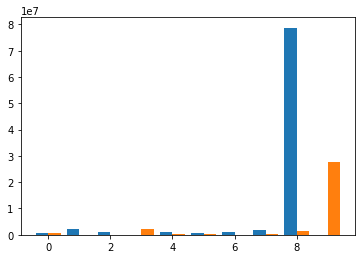

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# fig = plt.figure(figsize = (10,5))

# plt.bar(x-0.2, legacy, width)
# plt.bar(x+0.2, global1, width)
# plt.axis(legend)
# plt.show

labels  = query.loc[query['system_type'] == 'LEGACY', 'accessorial_charge_description']
legacy  = query.loc[query['system_type'] == 'LEGACY', 'count']
global1 = query.loc[query['system_type'] == 'GLOBAL', 'count']

x = np.arange(10)
width = 0.4

fig, ax = plt.subplots()
ax.bar(x - width/2, legacy, width)
ax.bar(x + width/2, global1, width)

# fig.show()